### Importing GT

In [12]:
import json
import numpy as np
from scipy.spatial.transform import Rotation as R
from compas.geometry import oriented_bounding_box_numpy
from pytorch3d.ops import box3d_overlap
import torch
import os
import open3d as o3d

IOU_THRESHOLD = 0.7
LABEL_FOLDER = "labels/"

gt_jsons = [f for f in os.listdir(LABEL_FOLDER) if f.endswith('.json') and "gt" in f]
pred_jsons = [f for f in os.listdir(LABEL_FOLDER) if f.endswith('.json') and "pred" in f]
gt_jsons.sort(), pred_jsons.sort()
gt_jsons = [file for file in gt_jsons if "515" not in file]
pred_jsons = [file for file in pred_jsons if "515" not in file]
gt_jsons, pred_jsons

(['1_cropped_gt.json',
  '2_cropped_gt.json',
  '3_gt.json',
  '5_gt.json',
  '7_gt.json'],
 ['1_cropped_pred.json',
  '2_cropped_pred.json',
  '3_pred.json',
  '5_pred.json',
  '7_pred.json'])

In [13]:
def compute_3d_IoU(box1, box2):
    box1 = torch.tensor(box1, dtype=torch.float32).unsqueeze(0)
    box2 = torch.tensor(box2, dtype=torch.float32).unsqueeze(0)
    vol, IoU =  box3d_overlap(box1, box2)

    return IoU.item()

In [14]:
points_unit = [
        [0.9, 0.9, 0.9],
        [0, 0, 0],
        [1, 0, 0],
        [1, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 1],
        [1, 1, 1],
        [0, 1, 1],
    ]
box = oriented_bounding_box_numpy(np.array(points_unit))
box

[[0.0, 1.0, 1.0],
 [1.0, 1.0, 1.0],
 [1.0, 0.0, 1.0],
 [0.0, 0.0, 1.0],
 [0.0, 1.0, 0.0],
 [1.0, 1.0, 0.0],
 [1.0, 0.0, 0.0],
 [0.0, 0.0, 0.0]]

In [15]:
def reorder_vertices(box):
    """
    A unit cube, defined with the pythorch3d convention, has the following vertices:
        [0, 0, 0],                    (4) +---------+. (5)
        [1, 0, 0],                        | ` .     |  ` .
        [1, 1, 0],                        | (0) +---+-----+ (1)
        [0, 1, 0],                        |     |   |     |
        [0, 0, 1],                    (7) +-----+---+. (6)|
        [1, 0, 1],                        ` .   |     ` . |
        [1, 1, 1],                        (3) ` +---------+ (2)
        [0, 1, 1],
    
    While the OrientedBoundingBox from Open3D has the following vertices:
       [0, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 1, 1],
       [0, 1, 1],
       [1, 0, 1],
       [1, 1, 0]

    This function reorders the vertices of the OrientedBoundingBox to match the pytorch3d convention.
    This allows to use the official IoU function from Pytorch3D.
    """
    assert box.shape == (8, 3)

    reordered = [
        box[0], box[1], box[7], box[2],
        box[3], box[6], box[4], box[5]
    ]
    return np.array(reordered)

In [16]:
def create_obb_from_description(centroid, dimensions, rotations):
    # Extract centroid, dimensions, and rotations
    cx, cy, cz = centroid["x"], centroid["y"], centroid["z"]
    length, width, height = dimensions["length"], dimensions["width"], dimensions["height"]
    rx, ry, rz = rotations["x"], rotations["y"], rotations["z"]

    # Create the 8 corners of the box before rotation and translation
    dx = length / 2
    dy = width / 2
    dz = height / 2

    corners = np.array([
        [-dx, -dy, -dz],
        [ dx, -dy, -dz],
        [ dx,  dy, -dz],
        [-dx,  dy, -dz],
        [-dx, -dy,  dz],
        [ dx, -dy,  dz],
        [ dx,  dy,  dz],
        [-dx,  dy,  dz]
    ])

    # Apply rotations
    rotation = R.from_euler('xyz', [rx, ry, rz], degrees=True)
    rotated_corners = rotation.apply(corners)

    # Apply translation (centroid)
    translated_corners = rotated_corners + np.array([cx, cy, cz])

    return translated_corners

In [17]:
class Obj:
    def __init__(self, label, bbox):
        assert isinstance(label, str)
        assert isinstance(bbox, o3d.geometry.OrientedBoundingBox)
        self.label = label
        self.bbox = reorder_vertices(np.asarray(bbox.get_box_points()))

class Gt_Obj(Obj):
    def __init__(self, label, bbox):
        super().__init__(label, bbox)
        self.points = None
        self.centroid = np.mean(bbox.get_box_points(), axis=0)
    def OBB(self):
        box = o3d.geometry.OrientedBoundingBox.create_from_points(o3d.utility.Vector3dVector(self.bbox))
        box.color = [0, 1, 0]
        return box

class Pred_Obj(Obj):
    def __init__(self, id, label, bbox, points, score):
        super().__init__(label, bbox)
        self.points = self.clean_points(points)
        self.centroid = np.mean(points, axis=0)
        self.id = id
        self.score = score
        self.bbox = oriented_bounding_box_numpy(self.points)
        self.bbox = reorder_vertices(np.asarray(self.OBB().get_box_points()))

    def OBB(self):
        box = o3d.geometry.OrientedBoundingBox.create_from_points(o3d.utility.Vector3dVector(self.bbox))
        box.color = [1, 0, 0]
        return box
    def clean_points(self, points):
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points)
        pcd.estimate_normals()
        clean, _ = pcd.remove_statistical_outlier(nb_neighbors=50, std_ratio=1.0)
        return np.asarray(clean.points)

class ObjList:
    def __init__(self, objects: list):
        assert isinstance(objects, list)
        assert all(isinstance(obj, Obj) for obj in objects)
        self.objects = objects

    def __getitem__(self, key):
        return self.objects[key]

    def __len__(self):
        return len(self.objects)

    def get_boxes_list(self):
        return [obj.bbox for obj in self.objects]

In [18]:
def load_gt(gt_json):
    for obj in gt_json["objects"]:
        obj["bbox"] = create_obb_from_description(
            obj["centroid"], obj["dimensions"], obj["rotations"]
        ).tolist()
    gt_objects = []
    for obj in gt_json["objects"]:
        v = o3d.utility.Vector3dVector(obj["bbox"])
        bbox = o3d.geometry.OrientedBoundingBox.create_from_points(v)
        gt_objects.append(Gt_Obj(obj["name"], bbox))

    return ObjList(gt_objects)


def load_pred(pred_json):
    predicted_objects = pred_json["objects"]
    for obj in predicted_objects:
        obj["bbox"] = np.array(obj["OBB"]).reshape(8, 3)
        obj["points"] = np.array(obj["points"]).reshape(-1, 3)
        obj["minimum_bbox"] = oriented_bounding_box_numpy(obj["points"])

    # Load predicted bboxes
    pred_objects = []
    for obj in predicted_objects:
        bbox = np.array(obj["minimum_bbox"]).reshape(8, 3)
        v = o3d.utility.Vector3dVector(bbox)
        if np.sum(bbox) == 0:
            continue
        try:
            bbox = o3d.geometry.OrientedBoundingBox.create_from_points(v)
            pred_objects.append(Pred_Obj(obj["id"], obj["label"], bbox, obj["points"], obj["score"]))
        except:
            pass

    return ObjList(pred_objects)


def load_data(gt_jsons, pred_jsons):
    DATA = {}
    gt_jsons.sort(), pred_jsons.sort()


    for i, (gt_json, pred_json) in enumerate(zip(gt_jsons, pred_jsons)):
        pc_path = json.load(open(LABEL_FOLDER + gt_json))["path"]
        pointCloud = o3d.io.read_point_cloud("../labelCloud/" + pc_path)
        gt_objects = load_gt(json.load(open(LABEL_FOLDER + gt_json)))
        pred_objects = load_pred(json.load(open(LABEL_FOLDER + pred_json)))
        DATA[i] = {
            "pointcloud": pointCloud,
            "gt": gt_objects,
            "pred": pred_objects,
        }

    return DATA


DATA = load_data(gt_jsons, pred_jsons)

In [19]:
idx = 0
label2idx = {}
for scene in DATA:
    gt_objects = DATA[scene]["gt"].objects
    pred_objects = DATA[scene]["pred"].objects
    for obj in gt_objects:
        if obj.label not in label2idx:
            label2idx[obj.label] = idx
            idx += 1

    for obj in pred_objects:
        if obj.label not in label2idx:
            label2idx[obj.label] = idx
            idx += 1

id2label = {v: k for k, v in label2idx.items()}
label2idx, id2label

({'tv': 0,
  'backpack': 1,
  'handbag': 2,
  'chair': 3,
  'laptop': 4,
  'bottle': 5,
  'person': 6,
  'dining table': 7,
  'mouse': 8,
  'couch': 9,
  'keyboard': 10,
  'scissors': 11,
  'mug': 12,
  'cup': 13,
  'toilet': 14,
  'cell phone': 15,
  'refrigerator': 16},
 {0: 'tv',
  1: 'backpack',
  2: 'handbag',
  3: 'chair',
  4: 'laptop',
  5: 'bottle',
  6: 'person',
  7: 'dining table',
  8: 'mouse',
  9: 'couch',
  10: 'keyboard',
  11: 'scissors',
  12: 'mug',
  13: 'cup',
  14: 'toilet',
  15: 'cell phone',
  16: 'refrigerator'})

In [20]:
def custom_draw_geometry(pcd, gt_objects, pred_objects):
    vis = o3d.visualization.Visualizer()
    vis.create_window()
    vis.add_geometry(pcd)

    for obj in gt_objects:
        vis.add_geometry(obj.OBB())

    for obj in pred_objects:
        vis.add_geometry(obj.OBB())

    vis.run()
    vis.destroy_window()

In [24]:
custom_draw_geometry(*DATA[4].values())

In [22]:
import matplotlib.pyplot as plt


# Associating GT and predicted objects
def compute_3d_iou_matrix(gt_boxes, pred_boxes):
    """
    Compute the 3D IoU matrix between GT and predicted objects.

    Parameters:
    - gt_boxes: list of GT OrientedBoundingBox objects.
    - pred_boxes: list of predicted OrientedBoundingBox objects.

    Returns:
    - numpy array: 2D array where element (i, j) is the IoU between GT object i and predicted object j.
    """
    iou_matrix = np.zeros((len(gt_boxes), len(pred_boxes)))
    for i, gt_box in enumerate(gt_boxes):
        for j, pred_box in enumerate(pred_boxes):
            iou_matrix[i, j] = compute_3d_IoU(gt_box, pred_box)
    return iou_matrix


def get_matches(gt_objects, pred_objects, iou_threshold=0.5):
    """
    Get the matched GT and predicted objects.
    returns:
     - matched_couples: list of dictionaries containing the matched GT and predicted objects and their IoU.
     - phantom_predictions: list of predicted objects that have no match.
     - missed_gt: list of GT objects that have no match.
    """

    gt_boxes = gt_objects.get_boxes_list()
    pred_boxes = pred_objects.get_boxes_list()
    iou_matrix = compute_3d_iou_matrix(gt_boxes, pred_boxes)

    matches = []
    for i, j in zip(*np.where(iou_matrix > iou_threshold)):
        matches.append({"gt": i, "pred": j, "iou": iou_matrix[i, j]})
    matches = sorted(matches, key=lambda x: x["iou"], reverse=True)

    matched_gt = set()
    matched_preds = set()
    matched_couples = []
    for match in matches:
        if match["gt"] not in matched_gt and match["pred"] not in matched_preds:
            matched_gt.add(match["gt"])
            matched_preds.add(match["pred"])
            matched_couples.append(
                {
                    "gt": gt_objects[match["gt"]],
                    "pred": pred_objects[match["pred"]],
                    "iou": match["iou"],
                }
            )

    phantom_preds = [
        pred_objects[i] for i in range(len(pred_objects)) if i not in matched_preds
    ]
    missed_gt = [gt_objects[i] for i in range(len(gt_objects)) if i not in matched_gt]

    ious = [match["iou"] for match in matched_couples]
    assert len(ious) == len(set(ious))
    assert len(matched_couples) + len(phantom_preds) == len(pred_objects)
    assert len(matched_couples) + len(missed_gt) == len(gt_objects)

    return matched_couples, phantom_preds, missed_gt

matching_dict, phantom_preds_dict, missed_gt_dict = {}, {}, {}
for scene in DATA:
    gt_objects = DATA[scene]["gt"]
    pred_objects = DATA[scene]["pred"]
    matching_dict[scene], phantom_preds_dict[scene], missed_gt_dict[scene] = get_matches(gt_objects, pred_objects, IOU_THRESHOLD)

In [23]:
scene = 3
print("GT objects that have no match: ", len(missed_gt_dict[scene]))
print("Predicted objects that have no match: ", len(phantom_preds_dict[scene]))
custom_draw_geometry(DATA[scene]["pointcloud"], missed_gt_dict[scene], phantom_preds_dict[scene])

GT objects that have no match:  13
Predicted objects that have no match:  19


In [95]:
matching, phantom_preds, missed_gt = [], [], []
for scene in DATA:
    matching.extend(matching_dict[scene])
    phantom_preds.extend(phantom_preds_dict[scene])
    missed_gt.extend(missed_gt_dict[scene])

In [96]:
def compute_confusion_matrix(matches, phantom_preds, missed_gt, label2idx, score_threshold=0.5):
    num_classes = len(label2idx)
    conf_matrix = np.zeros((num_classes + 1, num_classes + 1), dtype=np.int32)
    
    for match in matches:
        gt_idx = label2idx[match['gt'].label]
        pred_idx = label2idx[match['pred'].label]
        score = match['pred'].score

        if score >= score_threshold:
            conf_matrix[gt_idx, pred_idx] += 1
        else:
            conf_matrix[gt_idx, num_classes] += 1  # FN
            conf_matrix[num_classes, pred_idx] += 1  # FP
    
    for missed in missed_gt:
        gt_idx = label2idx[missed.label]
        conf_matrix[gt_idx, num_classes] += 1
    
    for phantom in phantom_preds:
        pred_idx = label2idx[phantom.label]
        conf_matrix[num_classes, pred_idx] += 1

    return conf_matrix

conf_matrix = compute_confusion_matrix(matching, phantom_preds, missed_gt, label2idx, 0.9)
#conf_matrix

In [97]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def compute_metrics_from_confusion_matrix(conf_matrix, num_classes):
    y_true = []
    y_pred = []
    
    for i in range(num_classes + 1):
        for j in range(num_classes + 1):
            y_true.extend([i] * conf_matrix[i, j])
            y_pred.extend([j] * conf_matrix[i, j])
    
    precision = precision_score(y_true, y_pred, average=None, labels=range(num_classes + 1), zero_division=1)
    recall = recall_score(y_true, y_pred, average=None, labels=range(num_classes + 1), zero_division=1)
    f1 = f1_score(y_true, y_pred, average=None, labels=range(num_classes + 1), zero_division=1)
    accuracy = accuracy_score(y_true, y_pred, normalize=True)
    
    return precision[:-1], recall[:-1], f1[:-1], accuracy

precision, recall, f1, accuracy = compute_metrics_from_confusion_matrix(conf_matrix, len(label2idx))
#precision, recall, f1, accuracy

In [98]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

def MAP(matching, phantom_preds, missed_gt, label2idx):
    n_samples = len(matching) + len(phantom_preds) + len(missed_gt)
    num_classes = len(label2idx)
    Y_true = np.zeros((n_samples, num_classes + 1), dtype=bool)
    Y_pred = np.zeros((n_samples, num_classes + 1), dtype=np.float32)

    for i, match in enumerate(matching):
        gt_idx = label2idx[match['gt'].label]
        pred_idx = label2idx[match['pred'].label]
        score = match['pred'].score

        Y_true[i, gt_idx] = True
        Y_pred[i, pred_idx] = score
    
    for i, missed in enumerate(missed_gt):
        gt_idx = label2idx[missed.label]
        Y_true[i + len(matching), gt_idx] = True
        Y_pred[i + len(matching), num_classes] = 0.0
    
    for i, phantom in enumerate(phantom_preds):
        pred_idx = label2idx[phantom.label]
        Y_pred[i + len(matching) + len(missed_gt), pred_idx] = phantom.score
        Y_true[i + len(matching) + len(missed_gt), num_classes] = True 
    
    precisions, recalls, thresholds = precision_recall_curve(Y_true.ravel(), Y_pred.ravel())
    
    MAP = average_precision_score(Y_true, Y_pred, average='weighted')
    return MAP, precisions, recalls, thresholds

mean_ap, precisions, recalls, thresholds = MAP(matching, phantom_preds, missed_gt, label2idx)
print(f"The mean Average Precision is: {mean_ap:.3f}")

The mean Average Precision is: 0.282


/Users/nicoloagostara/miniforge3/envs/ros_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/nicoloagostara/miniforge3/envs/ros_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


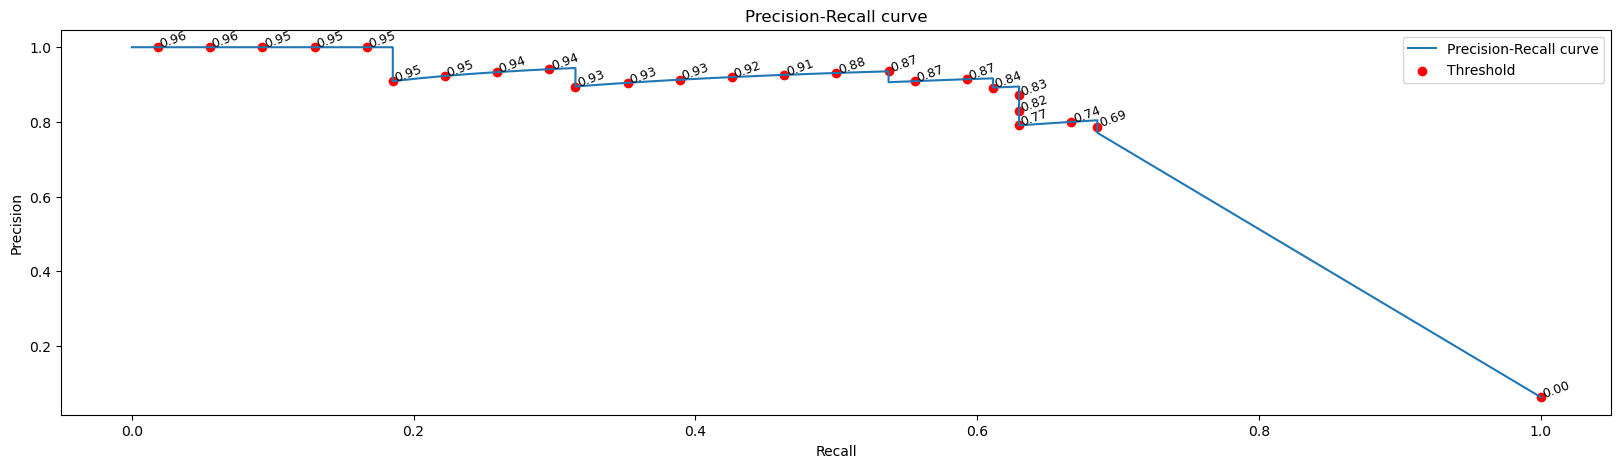

In [53]:
plt.figure(figsize=(20, 5))
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve")

for i in range(0, len(thresholds), 2):
    plt.text(recalls[i], precisions[i], f"{thresholds[i]:.2f}", fontsize=9, rotation=20)
    plt.scatter(recalls[i], precisions[i], color='red', label='Threshold', linewidths=1)

plt.legend(["Precision-Recall curve", "Threshold"])
plt.show()